In [1]:
import os
import numpy as np
import pandas as pd
import aplpy
from astropy.io import fits
from scipy.stats import norm
from spectral_cube import SpectralCube

## Load csv and extract gaussian results between 200 and 300 VLSR

In [2]:
df = pd.read_csv('./sf_p2_results.csv')
filtered_df = df[(df['VLSR'] >= 200) & (df['VLSR'] <= 300)]
filtered_df.head(10)

,x_pos,y_pos,GLON,GLAT,amp,e_amp,VLSR,e_VLSR,vel_disp,e_vel_disp,...,pvalue,aicc,rchi2,ncomps,ncomp_wmedian,ncomp_jumps,flag_blended,flag_neg_res_peak,flag_broad,flag_centroid
640,170,0,295.4359,14.9910,0.2022,0.0516,259.9960,0.2449,0.7817,0.2436,...,0.0005,-776.3337,1.6085,5,4,0,0,0,0,0
682,183,0,295.3724,13.9059,0.0709,0.0000,264.0638,0.0000,7.3206,0.0000,...,0.0138,-676.3551,1.7441,5,5,0,0,0,0,1
1212,285,0,295.0646,5.4099,0.1100,0.0000,255.4745,0.0000,9.7258,0.0000,...,0.1242,-797.0879,1.1735,8,8,0,0,0,0,0
1218,286,0,295.0632,5.3268,0.2324,0.0000,260.2020,0.0000,3.2186,0.0000,...,0.8221,-876.5787,1.4053,8,8,0,0,0,0,0
1219,286,0,295.0632,5.3268,0.1595,0.0000,272.5275,0.0000,1.8167,0.0000,...,0.8221,-876.5787,1.4053,8,8,0,0,0,0,0
1220,286,0,295.0632,5.3268,0.1718,0.0000,248.8839,0.0000,4.5892,0.0000,...,0.8221,-876.5787,1.4053,8,8,0,0,0,0,0
1862,170,1,295.3495,14.9869,0.2144,0.0000,260.6372,0.0000,0.6947,0.0000,...,0.0000,-807.1003,1.2104,5,4,0,0,0,0,1
1933,189,1,295.2593,13.4011,0.1521,0.0325,282.2200,0.4651,1.8858,0.4651,...,0.4613,-677.0630,1.0526,5,3,0,0,0,0,0
2030,212,1,295.1661,11.4829,0.0726,0.0104,254.1466,1.9605,11.8823,1.9605,...,0.5098,-1091.0564,1.1051,9,6,6,0,0,0,0
2037,213,1,295.1624,11.3995,0.1155,0.0000,287.3729,0.0000,2.4806,0.0000,...,0.0905,-832.1808,1.7940,7,5,1,0,0,0,0


## Construct model cube from extracted decomposition data

In [3]:
fits_path = './LAII.fits'
model = np.zeros_like(fits.getdata(fits_path))

for index, row in filtered_df.iterrows():
    x = int(row['x_pos'])
    y = int(row['y_pos'])
    amp = float(row['amp'])
    mean = float(row['VLSR'])
    std_dev = float(row['vel_disp'])
    gaussian = amp * norm.pdf(np.arange(model.shape[0]), mean, std_dev)
    model[:, y, x] += gaussian

#model = model[70:]
print(model.shape)

#  Save the model as a new FITS file. Copy the original header.
model_path = './model_LAII.fits'
hdu = fits.PrimaryHDU(data=model, header=fits.getheader(fits_path))
hdu.writeto(model_path, overwrite=True)

(302, 118, 287)


## Create moment maps from model

INFO: Auto-setting vmin to -7.910e+02 [aplpy.core]
INFO: Auto-setting vmax to  8.780e+03 [aplpy.core]


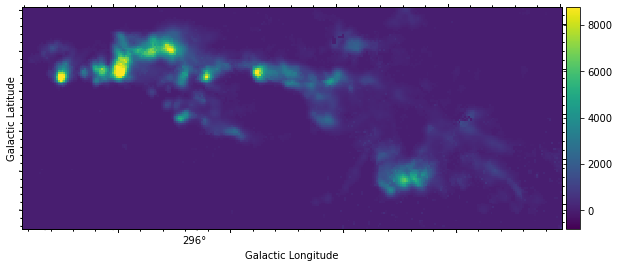

In [4]:
cube = SpectralCube.read('./model_LAII.fits')

#  Moment 0
moment_0 = cube.moment(order=0)
fig = aplpy.FITSFigure(moment_0.hdu)
fig.show_colorscale()
fig.add_colorbar()
fig.colorbar.show()
#fig.save('model_moment0.png')

/home/jdeboom/.local/lib/python3.10/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /


INFO: Auto-setting vmin to -3.862e+04 [aplpy.core]
INFO: Auto-setting vmax to  4.286e+05 [aplpy.core]


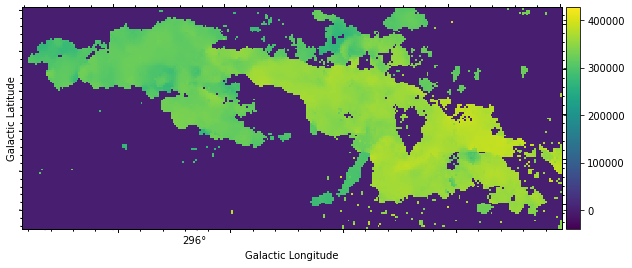

In [5]:
#  Moment 1
moment_1 = cube.moment(order=1)

#  Replace nan's with zero
moment_1[np.isnan(moment_1)] = 0

fig = aplpy.FITSFigure(moment_1.hdu)
fig.show_colorscale()
fig.add_colorbar()
fig.colorbar.show()
#fig.save('model_moment1.png')

## Create moment maps of the original subcube data for comparison

INFO: Auto-setting vmin to -2.765e+04 [aplpy.core]
INFO: Auto-setting vmax to  3.572e+05 [aplpy.core]


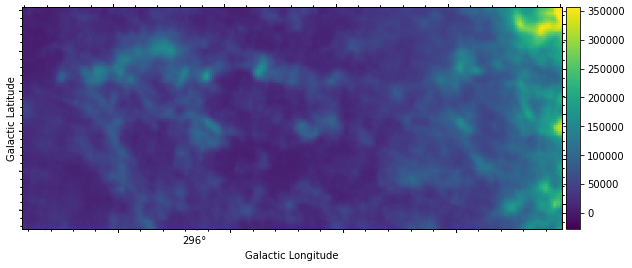

In [6]:
#  Moment 0
cube = SpectralCube.read('./LAII.fits')

moment_0 = cube.moment(order=0)
fig = aplpy.FITSFigure(moment_0.hdu)
fig.show_colorscale()
fig.add_colorbar()
fig.colorbar.show()
#fig.save('LAII_moment0.png')

INFO: Auto-setting vmin to -7.766e+03 [aplpy.core]
INFO: Auto-setting vmax to  2.379e+05 [aplpy.core]


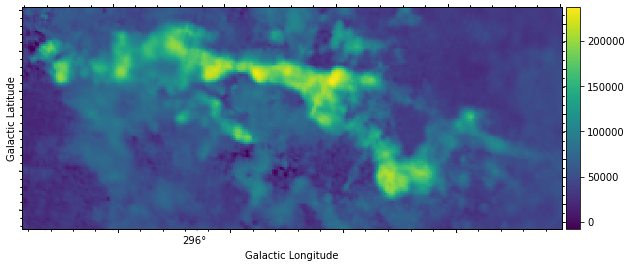

In [7]:
#  Moment 1
moment_1 = cube.moment(order=1)
fig = aplpy.FITSFigure(moment_1.hdu)
fig.show_colorscale()
fig.add_colorbar()
fig.colorbar.show()
#fig.save('LAII_moment1.png')

## Save slimmed cubes of both original data and model

In [11]:
#  Load data and model
data = fits.getdata('./LAII.fits')
model = fits.getdata('./model_LAII.fits')
print(data.shape)
print(model.shape)

#  Slim data and model
slim_data = data[70:]
slim_model = model[70:]
print(slim_data.shape)
print(slim_model.shape)

#  Save data and model as a new FITS file. Copy the original header.
hdu = fits.PrimaryHDU(data=slim_data, header=fits.getheader('./LAII.fits'))
hdu.writeto('./slim_LAII.fits', overwrite=True)

hdu = fits.PrimaryHDU(data=slim_model, header=fits.getheader('./LAII.fits'))
hdu.writeto('./model_slim_LAII.fits', overwrite=True)

(302, 118, 287)
(302, 118, 287)
(232, 118, 287)
(232, 118, 287)
